# Classical splittings with `expsolve.evolve.splittings`

In this notebook we will learn how to

* defining a time stepper (`stepper`),
* consistent and symmetric splittings (`consistent`, `symmetric`).

[Back to evolve quick introduction](00_quick_introduction.ipynb). 

*&#169; Copyright 2019-2023 Pranav Singh*

Use of this source code is governed by the MIT license that can be found in the LICENSE file.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import expsolve as es
import expsolve.discretize.tensorgrid as ex
import expsolve.evolve.splittings.classical as split

import torch
from torch import exp, sin, abs, real, pi, diag
from torch.linalg import matrix_exp

c:\ProgramData\Anaconda3\envs\torchcomplex\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Classical splittings

In the solution of ODEs and PDEs

$$ u' = f(u), \qquad u(0)=u_0, \qquad \text{where}\quad  f = f_A + f_B $$

we often try to approximate the exact flow under the vector field $f$ with splitting and composition of the flows $f_A$ and $f_B$ which are easier to compute. 

Let $\Phi$ be the true flow under $f$, i.e. the solution of our ODE/PDE is given by 

$$ u(t+h) = \Phi_h\ u(t),$$

### Trotter splitting

The most basic splitting involves solving the ODE/PDE 

$$ u'=f_A(u), \qquad u(0) = u_0 $$

under $f_A$ alone for a step of $h$, obtaining $\tilde{u}$, and then solving the ODE/PDE

$$ u'=f_B(u), \qquad u(0) = \tilde{u} $$

under $f_B$ alone for a step of $h$, obtaining $u_1 \approx u(h)$ where $u(h)$ is the true solution. 

Speaking more formally, $\tilde{u} = \Phi_h^A\, u_0$ is obtained from $u_0$ under the flow of $f_A$, i.e. $\Phi_h^A$, and $u_1$ is obtained from $\tilde{u}$ under the flow of $f_B$, i.e. $\Phi_h^B$. Overall,

$$ u_1 = \Phi_h^B \circ \Phi_h^A\ u_0 $$

We say that the effective numerical flow is given by 

$$ \Phi_h^{(1),(1)} =  \Phi_h^B \circ \Phi_h^A $$

and the numerical method constitutes applying this flow for each time step

$$ u_{n+1} = \Phi_h^{(1),(1)}\ u_n $$

This method is the lowest order (order 1) splitting called the Trotter or Lie--Trotter splitting.


### Strang splitting

A more accurate (order 2) splitting is the Strang splitting, given by 

$$ \Phi_h^{(0, 1),(\frac12, \frac12)} =  \Phi_{\frac{h}{2}}^B \circ \Phi_h^A \circ \Phi_{\frac{h}{2}}^B$$

### General (classical) splitting

In general, a splitting takes the following form:

$$ \Phi_h^{\alpha,\beta} =  \prod_{k=1}^{K} \Phi_{h \beta_k}^B \circ \Phi_{h \alpha_k}^A $$

where $\alpha$ and $\beta$ are vectors of length $K$ each. Note that the above product needs to be ordered since the product is not-abelian. We assume the convention 

$$ \prod_{k=1}^{K} \Phi_{h \beta_k}^B \circ \Phi_{h \alpha_k}^A \ = \ \Phi_{h \beta_K}^B \circ \Phi_{h \alpha_K}^A \circ \ldots \circ  \Phi_{h \beta_2}^B \circ \Phi_{h \alpha_2}^A \Phi_{h \beta_1}^B \circ \Phi_{h \alpha_1}^A $$

Some components of $alpha$ and $\beta$ may be $0$. If intermediate components, i.e. $\alpha_k$ for $1<k<K$ is $0$, the neighbouring $B$ (or, appropriately, $A$ in case of zero $\beta_k$) flows can be combined, and the splitting can be made shorter. Therefore, without loss of generality, we may assume no intermediate component is $0$. The total number of non-zero components ($\leq 2K$) in the splitting are called the number of *stages* (each stage represents an ODE/PDE solve). 


### Exponential splitting

In the case of a linear ODE/PDE,

$$ u' = (A+B) u, $$ 

the flows $\Phi_h^A$ and $\Phi_h^B$ are given by the matrix (or operator in case of PDE) exponentials,

$$ \Phi_h^A\ v= \exp(h A)\, v, \qquad \Phi_h^B\ v= \exp(h B)\, v $$

The Trotter splitting takes the form

$$ u_1 = \exp(h B)  \exp(h A)\ u_0 $$

or 

$$ \exp(h (A+B)) \approx \Phi_h^{(1),(1)} = \exp(h B)  \exp(h A) $$

The Strang splitting takes the form 

$$ u_1 = \exp\left(\frac{h}{2} B \right)  \exp(h A) \exp\left(\frac{h}{2} B \right) \ u_0 $$

or 

$$ \exp(h (A+B)) \approx \Phi_h^{(0, 1),(\frac12, \frac12)} = \exp\left(\frac{h}{2} B \right)  \exp(h A) \exp\left(\frac{h}{2} B \right) $$

and in general, a classical splitting defined by the vectors $\alpha$ and $\beta$ takes the form

$$ \exp(h (A+B)) \approx \prod_{k=1}^{K} \exp\left(h \beta_k B\right)\ \exp\left(h \alpha_k A \right)  \ = \ \exp\left(h \beta_K B\right) \exp\left(h \alpha_K A \right)  \ldots  \left(h \beta_2 B\right) \exp\left(h \alpha_2 A \right) \exp\left(h \beta_1 B\right) \exp\left(h \alpha_1 A \right)  $$

The matrix/operator exponentials may be computed exactly or further approximated, e.g. using methods such as Krylov subspace methods. 

### Grid, Initial Condition & Brute Force Solution

In [2]:
n = 200
L = 10
xr = [-L, L]
x = ex.grid1d(n, xr)

x0 = -2.0
u = exp(-(x-x0)**2/(2*0.25))
u = ex.normalize(u, xr)

V = x**4 - 10*x**2

trange = [0, 1]
D2 = ex.diffmatrix(2, n, xr)
H = -D2 + es.linalg.diag(V)
urefT = es.linalg.matmul(matrix_exp(-1j*(trange[1]-trange[0])*H) , u)

#### Observables

In [3]:
observables = {'energy': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr) + V*psi, u, xr), 
'position': lambda u, t: ex.observable(lambda psi: x*psi, u, xr), 
'momentum': lambda u, t: ex.observable(lambda psi: 1j*ex.diffop(0, 1, psi, xr), u, xr), 
'kinetic': lambda u, t: ex.observable(lambda psi: -ex.diffop(0, 2, psi, xr), u, xr), 
'potential':lambda u, t: ex.observable(lambda psi: V*psi, u, xr)}

In [6]:
for obsname in observables:
    op = observables[obsname]
    print(f'{obsname} changes from {op(u, torch.tensor(trange[0]))} to {op(urefT, torch.tensor(trange[1]))}')

energy changes from tensor([-20.2031], dtype=torch.float64) to tensor([-20.2031], dtype=torch.float64)
position changes from tensor([-2.0000], dtype=torch.float64) to tensor([-2.1985], dtype=torch.float64)
momentum changes from tensor([2.3622e-17], dtype=torch.float64) to tensor([0.5491], dtype=torch.float64)
kinetic changes from tensor([2.0000], dtype=torch.float64) to tensor([2.4721], dtype=torch.float64)
potential changes from tensor([-22.2031], dtype=torch.float64) to tensor([-22.6752], dtype=torch.float64)


## Defining subflows

The starting point of defining a splitting method is to provide methods for computaiton of the subflows $\Phi_{h\alpha_k}^A$ and $\Phi_{h\beta_k}^B$, or equivalently, of the exponential $\exp(h \alpha_k A)$ and $\exp(h\beta_k B)$. The subflow function should have the following form:

```Python
    w = eAu(t, h, c, u)
```
which should implement $w = \exp(h c A) u$. The parameter `t` is required for non-autonomous case (which is covered under the next tutorial: time ordered splittings). For now, ignore this parameter.

We create lambda functions for computing $\exp(i h c\, D_2) u$ and $\exp(-i h c\, \texttt{diag}(V)) u$.

In [7]:
eLu = lambda t, h, c, u: ex.diffopexp(0, 2, 1j*c*h, u, xr)
eVu = lambda t, h, c, u: exp(-1j*c*h*V)*u

## Strang splitting

A single step of Strang:

$$\exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) \exp\left(i h\, \mathbf{D}_2\right) \ \exp\left(- i \frac{h}{2}\, \texttt{diag}(V) \right) u_n $$

corresponds to 

$$ \alpha = [0.5, 0.5], \qquad \beta = [1., 0.] $$

when we take $A = - i\, \texttt{diag}(V) $ and $B = i\, \mathbf{D}_2$. 

#### $\star$ `stepper`

Given the individual flows, a single step of Strang splitting can be executed using `split.stepper`

```Python
    w = split.stepper(t, h, u, eAu, eBu, alpha, beta)
```

which returns $w \approx u(t+h)$ given $u(t)=u$. We can also create a stepper function using `lambda`.


In [8]:
strangstep = lambda t, h, ut: split.stepper(t, h, ut, eVu, eLu, alpha = [0.5, 0.5], beta = [1., 0.])

Once the stepper is ready, we can use `expsolve.solvediffeq` to simulate over `trange`$=[0,1]$.

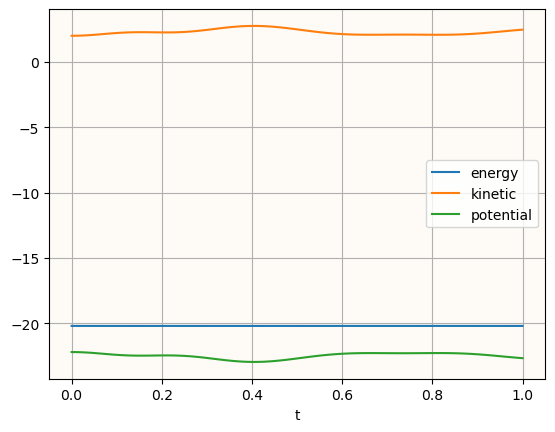

In [9]:
trange = [0, 1]
timegrid = es.timegrid(trange, ndt=100)
ustrangT, obsvalues, _ = es.solvediffeq(u, timegrid, strangstep, observables)

ex.obsplot(plt, timegrid, obsvalues, ['energy', 'kinetic','potential'])
plt.show()

### Analysing order of Strang

order of the Strang splitting is 2.0


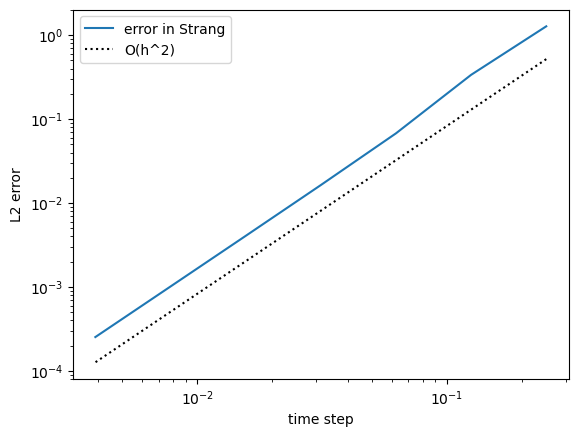

In [10]:
normfn = lambda u0, u1: ex.l2norm(u0-u1, xr)
ord, _ = es.order(u, urefT, normfn, trange, ndtlist=2**np.arange(2,9), steppers={'Strang':strangstep})
print(f'order of the Strang splitting is {ord["Strang"]}')

As before, we can see that the (global) error of Strang is $\mathcal{O}(h^2)$.

## Consistency \& Symmetry

#### $\star$  `consistent`

We don't always have to specify all the parameters of a splitting. For instance, a consistent scheme requires

$$ \sum_{k=1}^n \alpha_k = 1, \qquad \sum_{k=1}^n \beta_k = 1$$

So it suffices to specify the first $n$ coefficients, and compute $\alpha_n = 1-\sum_{k=1}^{n-1} \alpha_k$. This map is implemented as `split.consistent`

```Python
    alpha, beta = split.consistent(alphapartial, betapartial)
```
where `alphapartial` and `betapartial` are the $n-1$ length vectors of $\alpha_1, \ldots, \alpha_{n-1}$ and $\beta_1, \ldots, \beta_{n-1}$, while the outputs `alpha` and `beta` contain the full coefficients.  

#### Trotter

A consistent scheme has order $1$ at least. Trotter splitting is the simplest consistent splitting. It can be obtained by setting `alpha=[1.]` and `beta=[1.]`. Alternatively, it can be obtained using `split.consistent` with `alphapartial=betapartial=[]`.

In [11]:
trotteralpha, trotterbeta = split.consistent([],[])
print(f'alpha={trotteralpha}, beta={trotterbeta}')
trotterstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, trotteralpha, trotterbeta)

alpha=tensor([1.], dtype=torch.float64), beta=tensor([1.], dtype=torch.float64)


#### $\star$ `symmetric`

Another common constraint is symmetry. The idea for symmetry is that we want $\alpha_1 = \alpha_n$, $\alpha_2 = \alpha_{n-1}$ and so on. When talking about symmetry, please note that we always enforce consistency when enforcing symmetry. 


If `alphapartial` contains $\widetilde{\alpha}_1,\ldots, \widetilde{\alpha}_{m-1}$ and `betapartial` contains $\widetilde{\beta}_1,\ldots, \widetilde{\beta}_{m-1}$ (they are of the same length), the output `alpha` and `beta` are vectors of length `n=2m` and

$$\alpha = \widetilde{\alpha}_1, \ldots, \widetilde{\alpha}_{m-1} , \widetilde{\alpha}_{m}, \widetilde{\alpha}_{m}, \widetilde{\alpha}_{m-1}, \ldots, \widetilde{\alpha}_{1} \quad \text{where} \quad \widetilde{\alpha}_{m} = \frac12 - \sum_{k=1}^{m-1} \widetilde{\alpha}_k$$

and 

$$\beta = \widetilde{\beta}_1, \ldots, \widetilde{\beta}_{m-1} , \widetilde{\beta}_{m}, \widetilde{\beta}_{m-1}, \ldots, \widetilde{\beta}_{1}, 0\quad \text{where} \quad \widetilde{\beta}_{m} = 1 - 2\sum_{k=1}^{m-1} \widetilde{\beta}_k$$

If `alphapartial` contains $\widetilde{\alpha}_1,\ldots, \widetilde{\alpha}_{m}$ and `betapartial` contains $\widetilde{\beta}_1,\ldots, \widetilde{\beta}_{m-1}$, i.e. `alphapartial` has length one higher, the output `alpha` and `beta` are vectors of length `n=2m+1` and


$$\alpha = \widetilde{\alpha}_1, \ldots, \widetilde{\alpha}_{m} , \widetilde{\alpha}_{m+1}, \widetilde{\alpha}_{m}, \ldots, \widetilde{\alpha}_{1} \quad \text{where} \quad \widetilde{\alpha}_{m} = 1 - 2\sum_{k=1}^{m} \widetilde{\alpha}_k$$

and 

$$\beta = \widetilde{\beta}_1, \ldots, \widetilde{\beta}_{m-1} , \widetilde{\beta}_{m}, \widetilde{\beta}_{m}, \widetilde{\beta}_{m-1}, \ldots, \widetilde{\beta}_{1}, 0\quad \text{where} \quad \widetilde{\beta}_{m} = \frac12 - \sum_{k=1}^{m-1} \widetilde{\beta}_k$$

#### Strang

A consistent scheme has order $2$ at least. Strang splitting is the simplest symmetric splitting. It can be obtained by setting `alpha=[1.]` and `beta=[1.]`. Alternatively, it can be obtained using `split.symmetric` with `alphapartial=betapartial=[]`.

In [12]:
strangalpha, strangbeta = split.symmetric([],[])
print(f'alpha={strangalpha}, beta={strangbeta}')
strangstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, strangalpha, strangbeta)

alpha=tensor([0.5000, 0.5000], dtype=torch.float64), beta=tensor([1., 0.], dtype=torch.float64)


#### Blanes-Moan Order 4

A fourth-order consistent-symmetric scheme was given by Blanes Moan. The partial coefficients required for defining this symmetric splitting are

$$
a_1 = 0.0792036964311957, \quad
b_1 = 0.209515106613362, \quad
a_2 = 0.353172906049774, \quad
b_2 = −0.143851773179818, \quad
a_3 = −0.0420650803577195
$$

consistency enforces 

$$ b_3 = 1/2 − b_1 − b_2, \qquad 
a_4 = 1 − 2(a_1 + a_2 + a_3)$$

We get the full coefficients from the minimal coefficients using `split.symmetric`

In [13]:
a = torch.tensor([0.0792036964311957, 0.353172906049774, -0.0420650803577195], dtype=torch.float64)
b = torch.tensor([0.209515106613362, -0.143851773179818], dtype=torch.float64)
blanesmoanalpha, blanesmoanbeta = split.symmetric(a,b)
print(blanesmoanalpha, blanesmoanbeta)

tensor([ 0.0792,  0.3532, -0.0421,  0.2194, -0.0421,  0.3532,  0.0792],
       dtype=torch.float64) tensor([ 0.2095, -0.1439,  0.4343,  0.4343, -0.1439,  0.2095,  0.0000],
       dtype=torch.float64)


We can then create the Blanes Moan stepper

In [14]:
blanesmoanstep = lambda t, h, u0: split.stepper(t, h, u0, eVu, eLu, blanesmoanalpha, blanesmoanbeta)

## Analysing order of the various schemes

order of the Trotter splitting is 1.0
order of the Strang splitting is 2.0
order of the Blanes-Moan splitting is 4.0


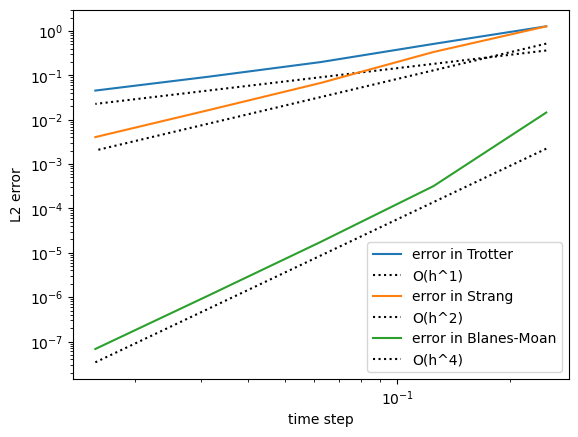

In [15]:
steppers = {'Trotter': trotterstep, 'Strang': strangstep, 'Blanes-Moan': blanesmoanstep}
ord, _ = es.order(u, urefT, normfn, trange, ndtlist=2**np.arange(2,7), steppers=steppers)

for methodname in steppers:
    print(f'order of the {methodname} splitting is {ord[methodname]}')

As we can see, the (global) error of Trotter is $\mathcal{O}(h)$, that for Strang is $\mathcal{O}(h^2)$ and for Blanes-Moan it is $\mathcal{O}(h^4)$.

## Observables

In [16]:
steppers = {'Trotter': trotterstep, 'Strang': strangstep, 'Blanes-Moan': blanesmoanstep}
uT = {}
uintermediate = {}
obsvalues = {}
for methodname in steppers:
    uT[methodname], obsvalues[methodname], uintermediate[methodname] = es.solvediffeq(u, timegrid, steppers[methodname], observables)    

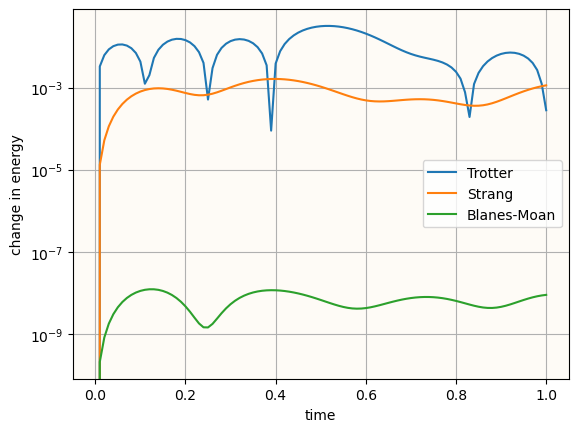

In [17]:
E0 = obsvalues['Trotter']['energy'][0][0]
lines = [((timegrid, abs(obsvalues[methodname]['energy']-E0)), {}, methodname) for methodname in obsvalues]

fig, ax = plt.subplots()
ex.semilogy(ax, linespecs=lines, xlabel='time', ylabel='change in energy', separatelines=True)
plt.show()

Splittings do not conserve energy exactly!